In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from datetime import datetime, timezone, timedelta

from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [5]:
data_filepath = './rawdata/Mar07_stepwise1.dat'

log_filepath = './log/PMX_2021-03-07.dat'

item_filepath = './Ether/item/items_2021-03-07.dat'
item = 'calibration'

storedir = './Ether/plots/'
storename_init = '20210307_stepwise1'

# input data and log

In [6]:
item_df = pd.read_csv(item_filepath, delim_whitespace=True)
item_df

,#Date,Time-Timezone,Item,Start/Stop
0,2021-03-07,00:35:01-UTC,calibration,start
1,2021-03-07,02:11:34-UTC,calibration,stop
2,2021-03-07,10:17:19-UTC,measurement,start
3,2021-03-07,11:50:03-UTC,measurement,start
4,2021-03-07,12:22:06-UTC,measurement,start
5,2021-03-07,12:24:09-UTC,measurement,start
6,2021-03-07,12:40:50-UTC,measurement,start
7,2021-03-07,13:38:15-UTC,measurement,stop
8,2021-03-07,14:22:54-UTC,calibration,start
9,2021-03-07,15:59:27-UTC,calibration,stop


In [ ]:
PRU_Clock_Counts = 200e6
Deg = 360/52000

start_line = np.where(item_df.iloc[:,2] == item)[0][-2]
start_at = item_df.iloc[:,0].to_numpy()[start_line] + ' ' + item_df.iloc[:,1].to_numpy()[start_line]
stop_at = item_df.iloc[:,0].to_numpy()[start_line + 1] + ' ' + item_df.iloc[:,1].to_numpy()[start_line + 1]

In [ ]:
df0 = pd.read_csv(log_filepath, delim_whitespace=True)
start_slice = np.where(start_at == df0.iloc[:,0].to_numpy()+' '+df0.iloc[:,1].to_numpy())[0][0]
stop_slice = np.where(stop_at == df0.iloc[:,0].to_numpy()+' '+df0.iloc[:,1].to_numpy())[0][0]

df = df0[start_slice:stop_slice]

In [13]:
time_category0, error0, direction0, timercount0, reference0 = np.loadtxt(data_filepath, comments='#', unpack=True)

## check the rawdata

Text(0, 0.5, 'difference counts of lines')

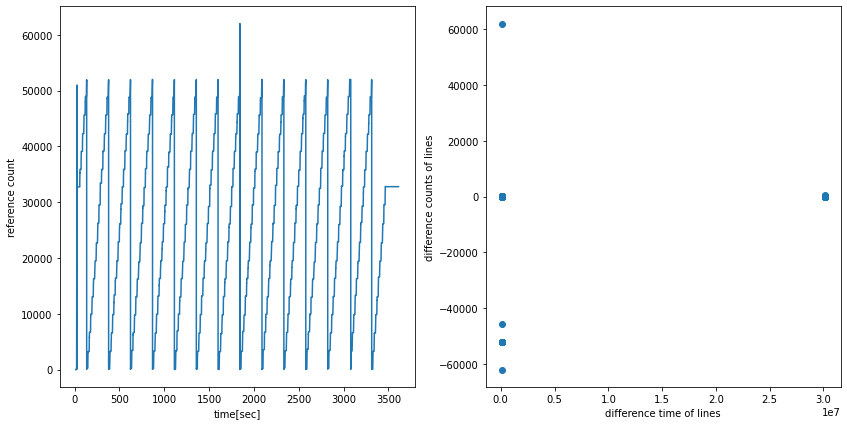

In [14]:
#first scketch of the rawdata
fig01, axarr01 = plt.subplots(1,2,figsize=(14,7))
ax01 = axarr01.ravel()

ax01[0].plot((timercount0/PRU_Clock_Counts)[::100], reference0[::100])
ax01[0].set_xlabel('time[sec]')
ax01[0].set_ylabel('reference count')

ax01[1].scatter(np.diff(timercount0), np.diff(reference0))
ax01[1].set_xlabel('difference time of lines')
ax01[1].set_ylabel('difference counts of lines')

In [15]:
missing_point = np.where((np.diff(timercount0) > 110000) | (np.diff(timercount0) < 90000))[0]
len(error_point)

15

In [16]:
for i in range(len(missing_point)):
    print(f'{np.diff(timercount0)[missing_point[i]]/200e6}')

0.15050294
0.15050289
0.150502805
0.15050278
0.15050265
0.15050284
0.15050286
0.1505412
0.15055507
0.15050671
0.150543945
0.1505028
0.150503015
0.150502755
0.150503065


# Set variables

In [18]:
# set matrix
if item == 'calibration':
    iteration = 100
    list_amp = [3.0]
    list_intv = ['0.100', '0.120', '0.140', '0.160', '0.180', '0.200', '0.220', '0.240', '0.260', '0.280', '0.300']
    matrix_size = 11
    pass
elif item == 'matrix':
    iteration = 100
    list_amp = [1.5, 1.8, 2.1, 2.4, 2.7, 3.0]
    list_intv = ['0.400', '0.800', '1.200', '1.600', '2.000', '2.400']
    matrix_size = 36
    pass
else:
    iteration = 16*num_laps
    list_amp = [3.0]
    list_intv = ['0.401']
    matrix_size = 1
    pass

pack_size = 1

In [19]:
plot_slice = 30
capture_slice = 500

capture_offset = 4

casp_threshold = -100

isUTC = False # True: UTC, False: JST

In [20]:
def packet_capture(dataframe, list_ampere, list_interval, UnixTime_Data):
    UTC = timezone(timedelta(hours=+0), 'UTC')
    JST = timezone(timedelta(hours=+9), 'JST')
    initial_UnixTime = []
    switching_UnixTime = []
    start_UnixTime = []

    for i in range(iteration):
        start_UnixTime.append([])

    for i in list_ampere:
        for j in list_interval:
            list_datetime = ((dataframe[dataframe.iloc[:,5] == i])[(dataframe[dataframe.iloc[:,5] == i]).iloc[:,8] == j]).iloc[:,0:2].to_numpy()
            for k in range(len(list_datetime)):
                if k%pack_size == 0:
                    if isUTC == True:
                        start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(UTC)).timestamp()
                        pass
                    else:
                        start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
                        pass
                    initial_UnixTime = np.append(initial_UnixTime, start_UnixTime[int(k/pack_size)])
                    pass
                pass
            switching_UnixTime.append(min(start_UnixTime))
            pass
        pass

    stop_UnixTime = dataframe[dataframe.iloc[:,2] == 'OFF'].iloc[-1,:]
    if isUTC == True:
        end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(UTC)).timestamp()
        pass
    else:
        end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
        pass

    captured_initials = []
    captured_switching = []
    
    for i in range(len(switching_UnixTime)):
        captured_switching.append(max(np.where(UnixTime_Data[::capture_slice] <= switching_UnixTime[i])[0]))
        pass
    
    for i in range(len(initial_UnixTime)):
        captured_initials.append(max(np.where(UnixTime_Data[::capture_slice] <= initial_UnixTime[i])[0]))
        pass
    
    captured_end = min(np.where(end_UnixTime + capture_offset <= UnixTime_Data[::capture_slice])[0])
    
    return captured_switching, captured_initials, captured_end

In [37]:
swt, inits, end = packet_capture(df, list_amp, list_intv, time_category0)

In [38]:
min(error0)

1.0

<span style="font-size: 200%; color: red;">Caution: Make sure there are no errors.</span>
* min(error0) = 1.0: no error catched

In [39]:
reference = reference0
ref_tmp = np.where(reference0 > 52000)[0]

for i in ref_tmp:
    reference[i] = reference0[i]-62000

In [40]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       df|   2130452|
|                      df0|   9812006|
|                    inits|      1928|
|                  item_df|      3606|


In [41]:
del df0, df

In [42]:
# divide by block
time = timercount0/PRU_Clock_Counts
time_block = []
reference_block = []

for i in range(len(swt)-1):
    slice0 = int(np.where(time == (time[::capture_slice])[swt[i]-capture_offset])[0])
    slice1 = int(np.where(time == (time[::capture_slice])[swt[i+1]-capture_offset])[0])
    time_block.append(time[slice0:slice1])
    reference_block.append(reference[slice0:slice1])
    pass
time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[-1]-capture_offset])[0])
                                                 :int(np.where(time == (time[::capture_slice])[end+capture_offset])[0])])
reference_block.append(reference[int(np.where(time == (time[::capture_slice])[swt[-1]-capture_offset])[0])
                                 :int(np.where(time == (time[::capture_slice])[end+capture_offset])[0])])

lincount_block = []
block_initials = []
onecycle_time = []
proceeded_degrees = []

for i in range(matrix_size):
    lincount_block.append([])
    lincount_block[i] = np.array(np.zeros(len(reference_block[i])))
    
    count_offset = 0
    casp_flag = 0
    casp = np.where(np.diff(reference_block[i]) <= casp_threshold)[0].tolist()

    for j in range(len(reference_block[i])):
        lincount_block[i][j] = reference_block[i][j]+count_offset
        if casp:
            if j == casp[casp_flag]:
                count_offset += reference_block[i][casp[casp_flag]]
                if len(casp) > casp_flag+1:
                    casp_flag += 1
                    pass
                pass
            pass
        pass
    
    block_initials.append([])
    for j in range(iteration):
        block_initials[i].append(int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*iteration:(i+1)*iteration])[j]-capture_offset])[0]))
        pass
    
    onecycle_time.append([])
    proceeded_degrees.append([])
    for j in range(iteration):
        if j != iteration - 1:
            onecycle_time[i].append(time_block[i][block_initials[i][j+1]]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][block_initials[i][j+1]]-lincount_block[i][block_initials[i][j]])*Deg)
            pass
        else:
            onecycle_time[i].append(time_block[i][-1]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][-1]-lincount_block[i][block_initials[i][j]])*Deg)
        pass
    pass

In [ ]:
cut_threshold = 2.3

## set variables (cont. for calibration of the wiregrid)

In [31]:
# error
ref_threshold = 100
error_pack = []

for i in range(matrix_size):
    except_sum = []
    except_sum.append(i)
    for j in range(iteration):
        if j != iteration - 1:
            tmp_timeblock = time_block[i][block_initials[i][j]:block_initials[i][j+1]]-time_block[i][block_initials[i][j]]
            place = min(np.where(tmp_timeblock >= cut_threshold)[0])
            except_ref = np.where(np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice]) > ref_threshold)[0]
            pass
        else:
            tmp_timeblock = time_block[i][block_initials[i][j]:-1]-time_block[i][block_initials[i][j]]
            place = min(np.where(tmp_timeblock >= cut_threshold)[0])
            except_ref = np.where(np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice]) > ref_threshold)[0]
            pass
        if except_ref:
            except_sum.append(j)
        pass
    if len(except_sum) < 2:
        del except_sum[0]
        pass
    if except_sum:
        error_pack.append(except_sum)
        pass
    pass

if not error_pack:
    error_pack = [[0]]

error_pack

/home/hnakata/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[[0]]

In [32]:
#avoid error
error_position = []
error_flag0 = 0

error_flag2 = 0

for i in range(matrix_size):
    error_flag1 = 1
    error_position.append([])
    for j in range(iteration):
        if i == error_pack[error_flag0][0]:
            if error_flag1 <= len(error_pack[error_flag0])-1:
                if j == error_pack[error_flag0][error_flag1]:
                    #print(f'{error_pack[error_flag0][0]} {error_pack[error_flag0][error_flag1]}')
                    error_position[i].append([])
                    error_position[i][j] = False
                    error_flag1 += 1
                    error_flag2 = 1
                    pass
                else:
                    error_position[i].append([])
                    error_position[i][j] = True
                    pass
                pass
            else:
                error_position[i].append([])
                error_position[i][j] = True
                pass
            pass
        else:
            error_position[i].append([])
            error_position[i][j] = True
            pass
        pass
    if error_flag2 == 1:
        if error_flag0 != len(error_pack)-1:
            error_flag0 += 1
            error_flag2 = 0
            pass
        pass
    pass

# Plots

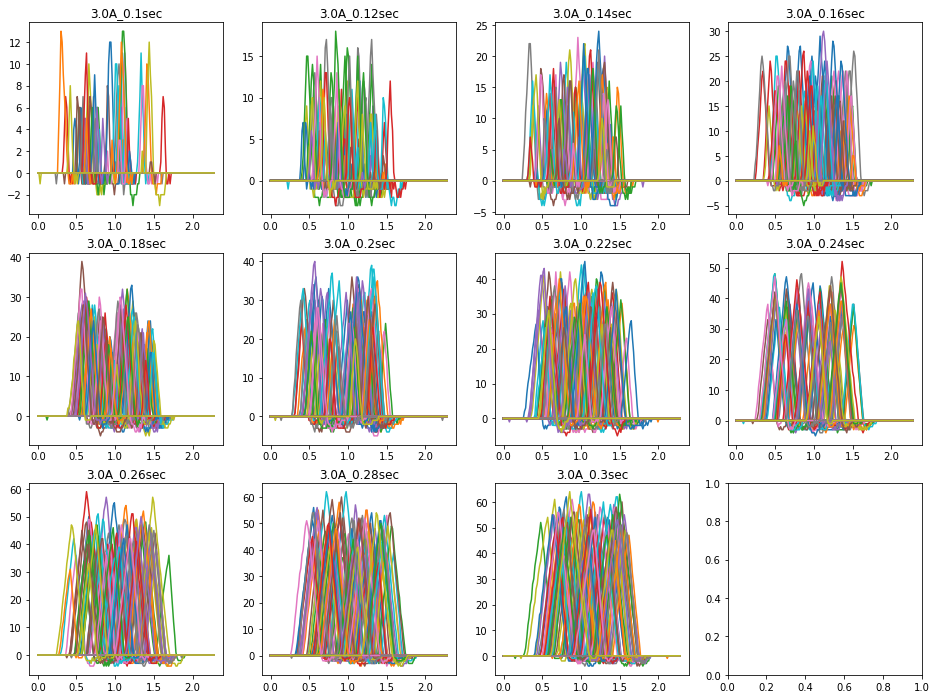

In [56]:
# shape of the each command
fig10, axarr10 = plt.subplots(3,4,figsize=(16,12))
plt.rcParams["font.size"] = 10
ax10 = axarr10.ravel()

for i in range(matrix_size):
    for j in range(iteration-1):
        if error_position[i][j] != False:
            if j != iteration - 1:
                tmp_timeblock = time_block[i][block_initials[i][j]:block_initials[i][j+1]]-time_block[i][block_initials[i][j]]
                place = min(np.where(tmp_timeblock >= cut_threshold)[0])
                ax10[i].plot(((time_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                            np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice]))
                pass
            else:
                tmp_timeblock = time_block[i][block_initials[i][j]:-1]-time_block[i][block_initials[i][j]]
                place = min(np.where(tmp_timeblock >= cut_threshold)[0])
                ax10[i].plot(((time_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                            np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j] + place])[::plot_slice]))
            pass
        pass
    ax10[i].set_title(f'3.0A_{round(0.10+0.02*i,2)}sec', fontsize=12)
    pass

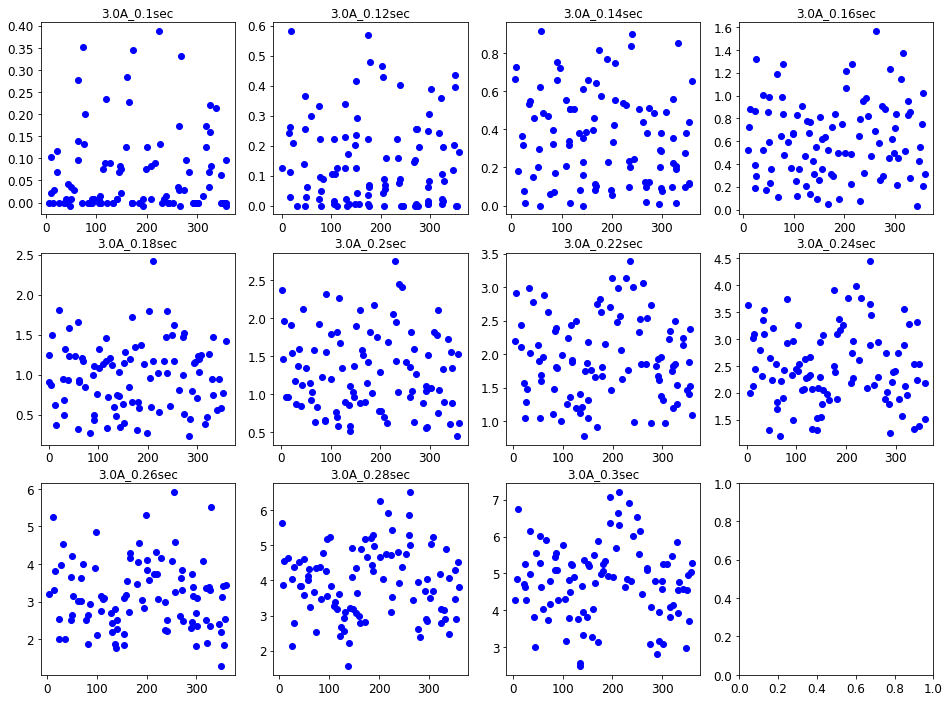

In [54]:
# position v.s. proceeded angle
moved_angle = []
start_position = []

fig11, axarr11 = plt.subplots(3,4,figsize=(16,12))
plt.rcParams["font.size"] = 10
ax11 = axarr11.ravel()

for i in range(matrix_size):
    moved_angle.append([])
    start_position.append([])
    for j in range(iteration-1):
        if error_position[i][j] != False:
            if j != iteration - 1:
                tmp_timeblock = time_block[i][block_initials[i][j]:block_initials[i][j+1]]-time_block[i][block_initials[i][j]]
                place = min(np.where(tmp_timeblock >= cut_threshold)[0])
                moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
                start_position[i].append(lincount_block[i][block_initials[i][j]]%52000*Deg)
                pass
            else:
                tmp_timeblock = time_block[i][block_initials[i][j]:-1]-time_block[i][block_initials[i][j]]
                place = min(np.where(tmp_timeblock >= cut_threshold)[0])
                moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
                start_position[i].append(lincount_block[i][block_initials[i][j]]%52000*Deg)
            pass
    ax11[i].scatter(start_position[i], moved_angle[i], color='b')
    ax11[i].set_title(f'3.0A_{round(0.10+0.02*i,2)}sec', fontsize=12)

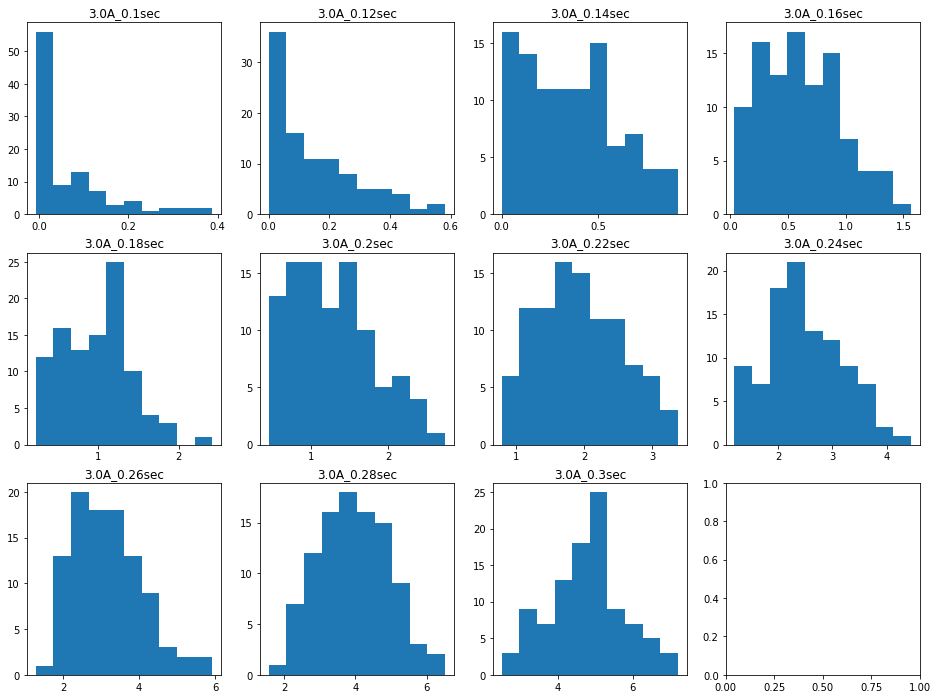

In [57]:
# histogram of proceeded angle
fig12, axarr12 = plt.subplots(3,4,figsize=(16,12))
plt.rcParams["font.size"] = 15
ax12 = axarr12.ravel()

for i in range(matrix_size):
    ax12[i].hist(moved_angle[i], bins=10)
    ax12[i].set_title(f'3.0A_{round(0.10+0.02*i,2)}sec', fontsize=12)

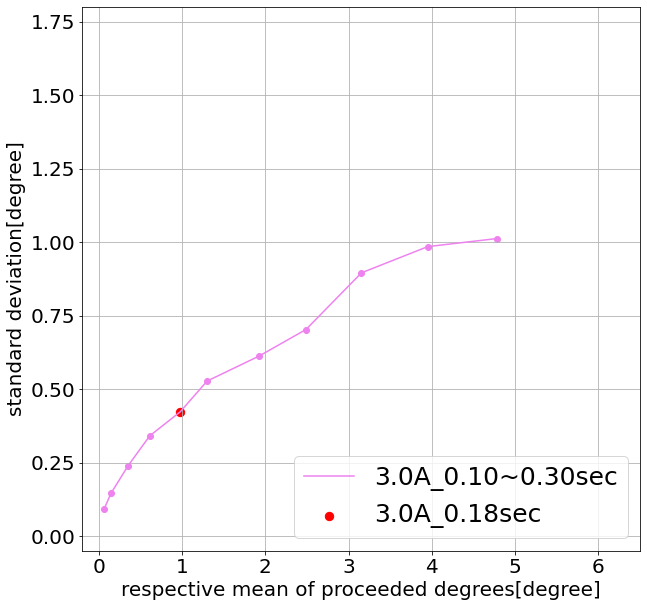

In [58]:
# mean of proceeded angles v.s. std dev
movDeg_mean = []
movDeg_stdv = []

for i in range(matrix_size):
    movDeg_mean.append(np.mean(moved_angle[i]))
    movDeg_stdv.append(np.std(moved_angle[i]))
    pass

fig13 = plt.figure(figsize=(10,10))
plt.rcParams["font.size"] = 20

plt.plot(movDeg_mean, movDeg_stdv, label=f'3.0A_0.10~0.30sec', color='violet')
plt.scatter(movDeg_mean, movDeg_stdv, color='violet')
plt.scatter(movDeg_mean[4], movDeg_stdv[4], color='r', s=70, label=f'3.0A_0.18sec')

plt.xlim([-0.2,6.5])
plt.ylim([-0.05,1.8])

plt.xlabel('respective mean of proceeded degrees[degree]')
plt.ylabel('standard deviation[degree]')
plt.grid()
plt.legend(loc='lower right', fontsize=25)

In [59]:
def set_feedback_value(mean_deg_list, deg_range):
    commanded_list = np.arange(0.101, 0.321, 0.02)
    commanded_value = []
    
    for i in range(deg_range):
        dist0 = (i+1) - mean_deg_list[commanded_list.tolist().index(max(commanded_list[np.array(mean_deg_list) < (i+1)]))]
        dist1 = mean_deg_list[commanded_list.tolist().index(min(commanded_list[np.array(mean_deg_list) > (i+1)]))] - (i+1)
        if (np.abs(dist1 - dist0) > 0.5) & (np.sign(dist1 - dist0) == 1.0):
            candidate0 = round(max(commanded_list[np.array(mean_deg_list) < (i+1)]),3)
            pass
        elif (np.abs(dist1 - dist0) > 0.5) & (np.sign(dist1 - dist0) == -1.0):
            candidate0 = round(min(commanded_list[np.array(mean_deg_list) > (i+1)]),3)
            pass
        else:
            candidate0 = round((min(commanded_list[np.array(mean_deg_list) > (i+1)]) + max(commanded_list[np.array(mean_deg_list) < (i+1)]))/2,3)
            pass
        commanded_value.append(candidate0)
        pass
    
    return commanded_value

In [60]:
# confirm the feedback time value
try:
    commanded_value = set_feedback_value(movDeg_mean, 5)
except ValueError:
    commanded_value = set_feedback_value(movDeg_mean,4)
    commanded_value.append(0.301)
    pass

commanded_value

[0.191, 0.231, 0.251, 0.281, 0.301]

# Others